#### Importing Modules

In [54]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tqdm import tqdm
import spacy
import re
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from typing import List
import os
import pickle
import calamancy 

In [55]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/mbchavez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Setting up Dataset

In [56]:
print("Dataset: ")
language = pd.read_csv("../data/final_annotations.csv")

language.head()

Dataset: 


,word_id,sentence_id,word,label,is_ne,is_spelling_correct
0,45,1,Gusto,FIL,NaN,True
1,46,1,kong,FIL,NaN,True
2,47,1,intindihin,FIL,NaN,True
3,48,1,pero,FIL,NaN,True
4,49,1,hindi,FIL,NaN,True


#### Join Sentences

In [57]:
# Ensure words are strings
language["word"] = language["word"].astype(str)

# Group by sentence_id and combine words
sentences = language.groupby("sentence_id")["word"].apply(lambda x: " ".join(x))

# Map the combined sentence back to the original dataframe
language["sentence"] = language["sentence_id"].map(sentences)

language.head()

,word_id,sentence_id,word,label,is_ne,is_spelling_correct,sentence
0,45,1,Gusto,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...
1,46,1,kong,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...
2,47,1,intindihin,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...
3,48,1,pero,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...
4,49,1,hindi,FIL,NaN,True,Gusto kong intindihin pero hindi ko maintindih...


### Load Sentence Transformer Model

In [58]:
# Load HuggingFace Sentence Transformer Model
mpnet_model = SentenceTransformer('all-mpnet-base-v2')

/home/mbchavez/Coding/Learn/csintsy-projects/csintsy-mco2-pinoybot/venv/lib64/python3.13/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#### Convert the Individuals Words into Embeddings

In [59]:
#Generate embeddings for words
print(len(language['word']), " words found.")

print("Getting Word Embedding...")
#Generate embeddings for words
language['word_embeddings'] = list(
        mpnet_model.encode(
            language["word"].tolist(), convert_to_tensor=False, show_progress_bar=True
        )
    )

language['word_embeddings']

23150  words found.
Getting Word Embedding...


Batches: 100%|██████████| 724/724 [01:41<00:00,  7.11it/s]


0        [-0.015572627, 0.05882696, -0.02446479, -0.032...
1        [0.07406978, 0.035357483, -0.027739374, -0.028...
2        [-0.052020285, -0.033879783, -0.04971939, 0.01...
3        [-0.0506149, 0.026319128, -0.0010626945, -0.02...
4        [0.030711884, -0.00059579074, -0.017216908, 0....
                               ...                        
23145    [-0.0093519455, -0.06878516, -0.044534426, -0....
23146    [0.063009344, 0.020623386, 0.0049647195, -0.03...
23147    [0.045219544, 0.008649993, -0.026441053, 0.015...
23148    [-0.021650821, 0.03991619, 0.0031559265, -0.05...
23149    [-0.011788345, 0.061924104, -0.0068219206, 0.0...
Name: word_embeddings, Length: 23150, dtype: object

#### Convert the Sentences Into Embeddings

In [60]:
# Get unique sentences per sentence_id
sentence_df = language.groupby("sentence_id")["sentence"].first().reset_index()

print(len(sentence_df), "sentences found.")

# Generate embeddings for unique sentences
print("Getting Sentence Embeddings...")
sentence_df["sentence_embeddings"] = list(
    mpnet_model.encode(
        sentence_df["sentence"].tolist(),
        convert_to_tensor=False,
        show_progress_bar=True
    )
)

# Map the embeddings back to the main dataframe
language = language.merge(
    sentence_df[["sentence_id", "sentence_embeddings"]],
    on="sentence_id",
    how="left"
)

language["sentence_embeddings"]


1310 sentences found.
Getting Sentence Embeddings...


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches: 100%|██████████| 41/41 [00:49<00:00,  1.22s/it]


0        [-0.009717632, -0.06712133, -0.03707916, 0.028...
1        [-0.009717632, -0.06712133, -0.03707916, 0.028...
2        [-0.009717632, -0.06712133, -0.03707916, 0.028...
3        [-0.009717632, -0.06712133, -0.03707916, 0.028...
4        [-0.009717632, -0.06712133, -0.03707916, 0.028...
                               ...                        
23145    [0.049423873, -0.06350867, 0.02032484, -0.0014...
23146    [0.049423873, -0.06350867, 0.02032484, -0.0014...
23147    [0.049423873, -0.06350867, 0.02032484, -0.0014...
23148    [0.049423873, -0.06350867, 0.02032484, -0.0014...
23149    [0.049423873, -0.06350867, 0.02032484, -0.0014...
Name: sentence_embeddings, Length: 23150, dtype: object

### Extracting Other Features

In [61]:
#Extract Names Entity labels
language['is_ne'].value_counts(dropna=False)
language['is_ne'] = language['is_ne'].fillna('NONE')
language['is_ne']

ne_features = pd.get_dummies(language['is_ne'], prefix='is_ne')

ne_features.head()


,is_ne_ABB,is_ne_ABB_EXPR,is_ne_ABB_NE,is_ne_EXPR,is_ne_NE,is_ne_NONE
0,False,False,False,False,False,True
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,False,False,False,True
4,False,False,False,False,False,True


In [62]:
#Extract Spelling Correctness labels
is_spelling_correct = language["is_spelling_correct"].astype(int).to_numpy().reshape(-1,1)

is_spelling_correct

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], shape=(23150, 1))

In [63]:
# def classify_if_is_spelling_correct(token: str) -> int:
#     """
#     Classifies if a token is spelled correctly.
#     Args:
#         token: The word token (string).
#     Returns:
#         is_correct: 1 if spelled correctly, 0 otherwise.
#     """
#     # spell = SpellChecker()

#     return 1 if token in spell else 0

In [64]:
# classify_if_is_spelling_correct("kasalanan")

In [65]:
# Load English and Tagalog pipelines
nlp = calamancy.load("tl_calamancy_md-0.1.0")

abbr_pattern = r'^([A-Z]\.){2,}$|^[A-Z]{2,5}$'  

def is_abbreviation(token):
    if token.isupper():
        if 2 <= len(token) <= 5 and re.match(abbr_pattern, token):
            return True
        else:
            return False
    return False

def classify_if_is_ne(token: str) -> str:
    """
    Classifies if a token is a named entity.
    Args:
        token: The word token (string).
    Returns:
        "ABB_NE" -> abbreviation named entity
        "NE" -> named entity
        "NONE" -> neither
        "EXPR" -> expression
    """
    doc = nlp(token)
    ent_type = doc[0].ent_type_
    is_ne = bool(ent_type)
    is_abbr = is_abbreviation(token)

    if is_ne and is_abbr:
        return "ABB_NE"
    elif is_ne:
        return "NE"
    elif is_abbr:
        return "ABB"
    else:
        return "NONE"

/home/mbchavez/Coding/Learn/csintsy-projects/csintsy-mco2-pinoybot/venv/lib64/python3.13/site-packages/spacy/util.py:930: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.8.7,<3.9.0
  warnings.warn(warn_msg)


In [66]:
classify_if_is_ne("MARAMING")

'NONE'

#### Orthographic Features

In [67]:
def get_ortographic_features(token: str):
    """
    Extract orthographic features for a given token.
    Args:
        token: The word token (string).
    Returns:
        features: A numpy array of orthographic features.
    """
    features = []

    token_lower = token.lower()
    length = len(token)

    # Basic orthographic features
    features.append(length)  # Length of the token
    features.append(int(token.islower()))  # All lowercase
    features.append(int(token.isupper()))  # All uppercase
    features.append(int(token.istitle()))  # Title case
    features.append(int(token.isdigit()))  # Numeric
    features.append(int(any(c.isdigit() for c in token)))  # Contains digit
    features.append(int(any(c.isalpha() for c in token)))  # Contains alphabetic
    features.append(int(any(not c.isalnum() for c in token)))  # Contains special char

    # Character composition
    vowels = set("aeiouAEIOU")
    vowel_ratio = sum(c in vowels for c in token) / max(length, 1)
    features.append(vowel_ratio)

    # Common Filipino / English letter patterns
    patterns = ['ng', 'mga', 'th', 'sh', 'ay', 'ts', 'ch']
    features.extend(int(p in token_lower) for p in patterns)

    # Prefixes / suffixes (morphological clues)
    filipino_prefixes = ['mag', 'nag', 'pag', 'ka', 'pa', 'ma', 'pinaka']
    filipino_suffixes = ['in', 'an', 'ang', 'han', 'hin', 'ing']
    english_suffixes = ['ing', 'tion', 'ness', 'ment', 'ly', 'ed', 'ee', 'er', 'ist', 'able']

    features.append(int(any(token_lower.startswith(p) for p in filipino_prefixes)))
    features.append(int(any(token_lower.endswith(s) for s in filipino_suffixes + english_suffixes)))

    # Explicit "-ee" ending
    features.append(int(token_lower.endswith('ee')))

    # Non-ASCII characters
    features.append(int(any(ord(c) > 127 for c in token)))

    return np.array(features)

#### Training the Model From the Extracted Featurse

In [68]:
# Prepare Word and Sentence Embeddings
word_embeddings = np.vstack(language["word_embeddings"])
sentence_embeddings = np.vstack(language["sentence_embeddings"])

# Prepare Orthographic Features
ortographic_features = np.vstack([get_ortographic_features(token) for token in language["word"]])


X = np.hstack([word_embeddings,ortographic_features,ne_features])
y = language["label"]

# 70% Train, 15% Validation, 15% Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 30% of 30% = 15% Validation, 15% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 16205, Validation: 3472, Test: 3473


In [69]:
print("Apply PCA...")
pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

print(f"PCA retained {np.sum(pca.explained_variance_ratio_):.2%} of variance")

print("Training the model...")
clf = RandomForestClassifier(n_estimators=300, random_state=42,verbose=1)
clf.fit(X_train, y_train)

Apply PCA...
PCA retained 95.11% of variance
Training the model...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    6.5s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   10.2s finished


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Visualize the Trees from the Random Forest

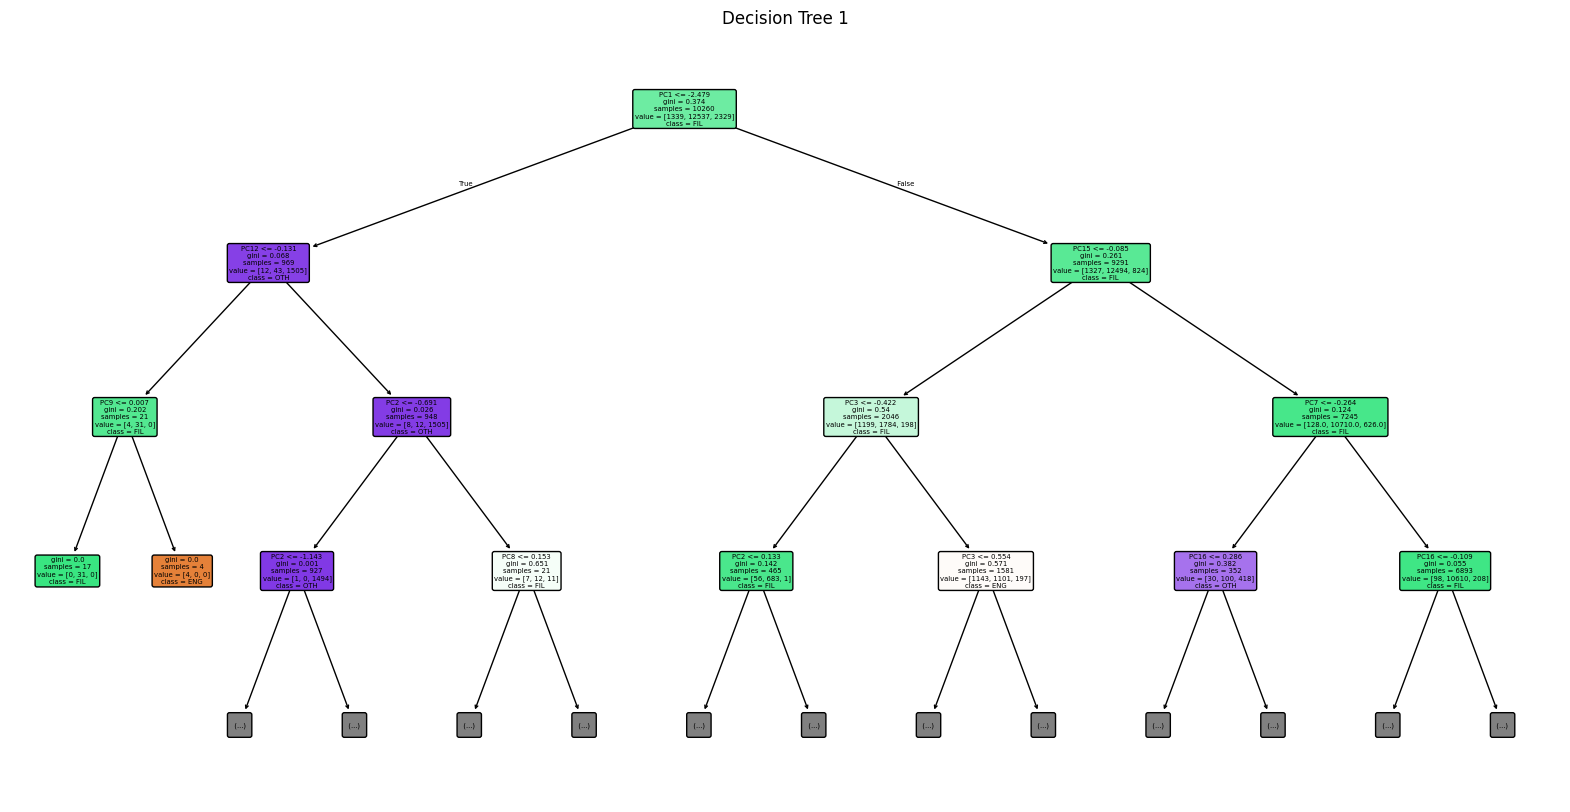

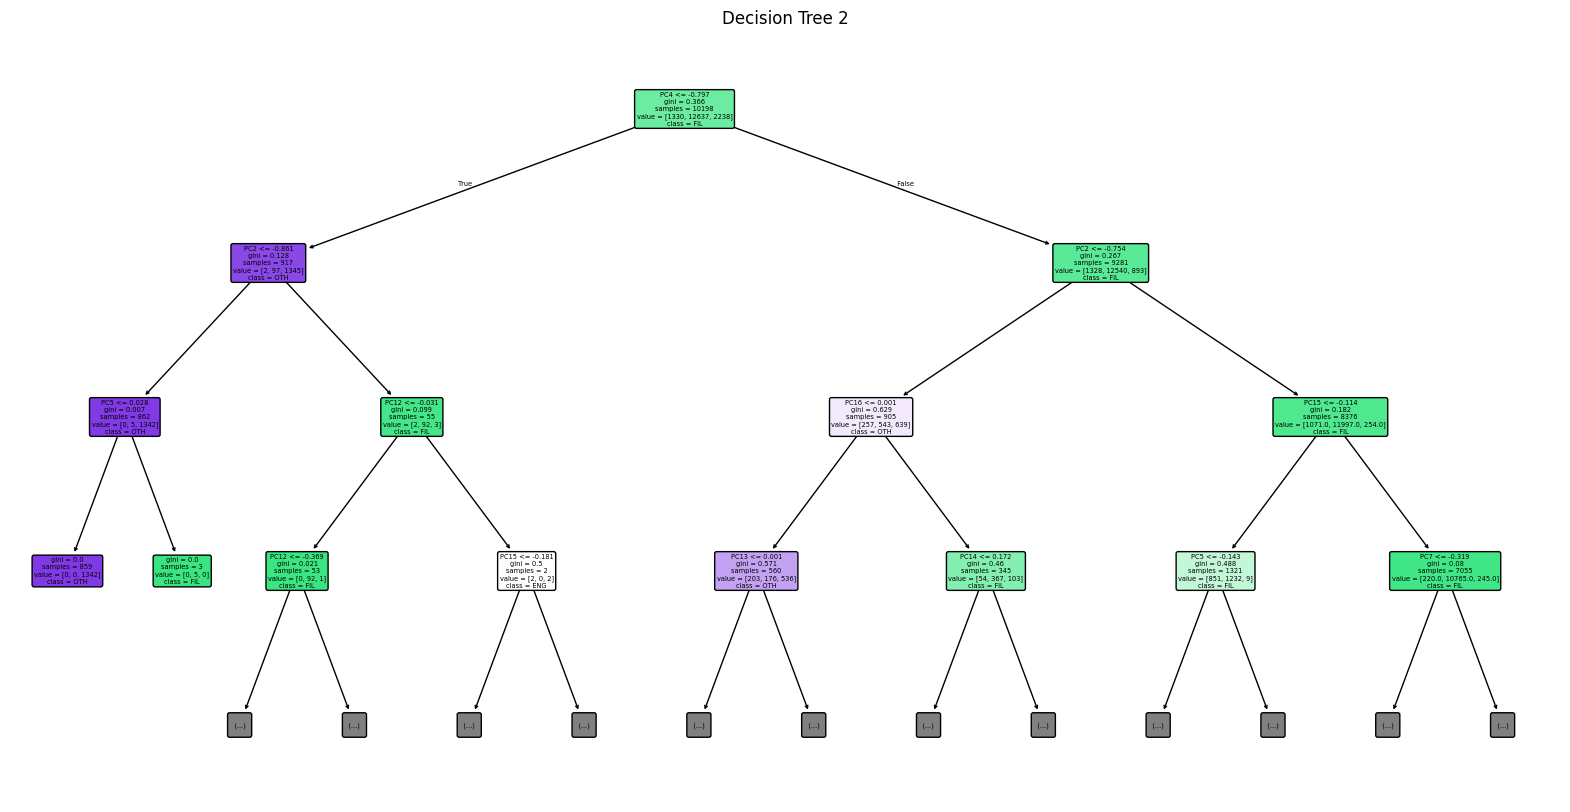

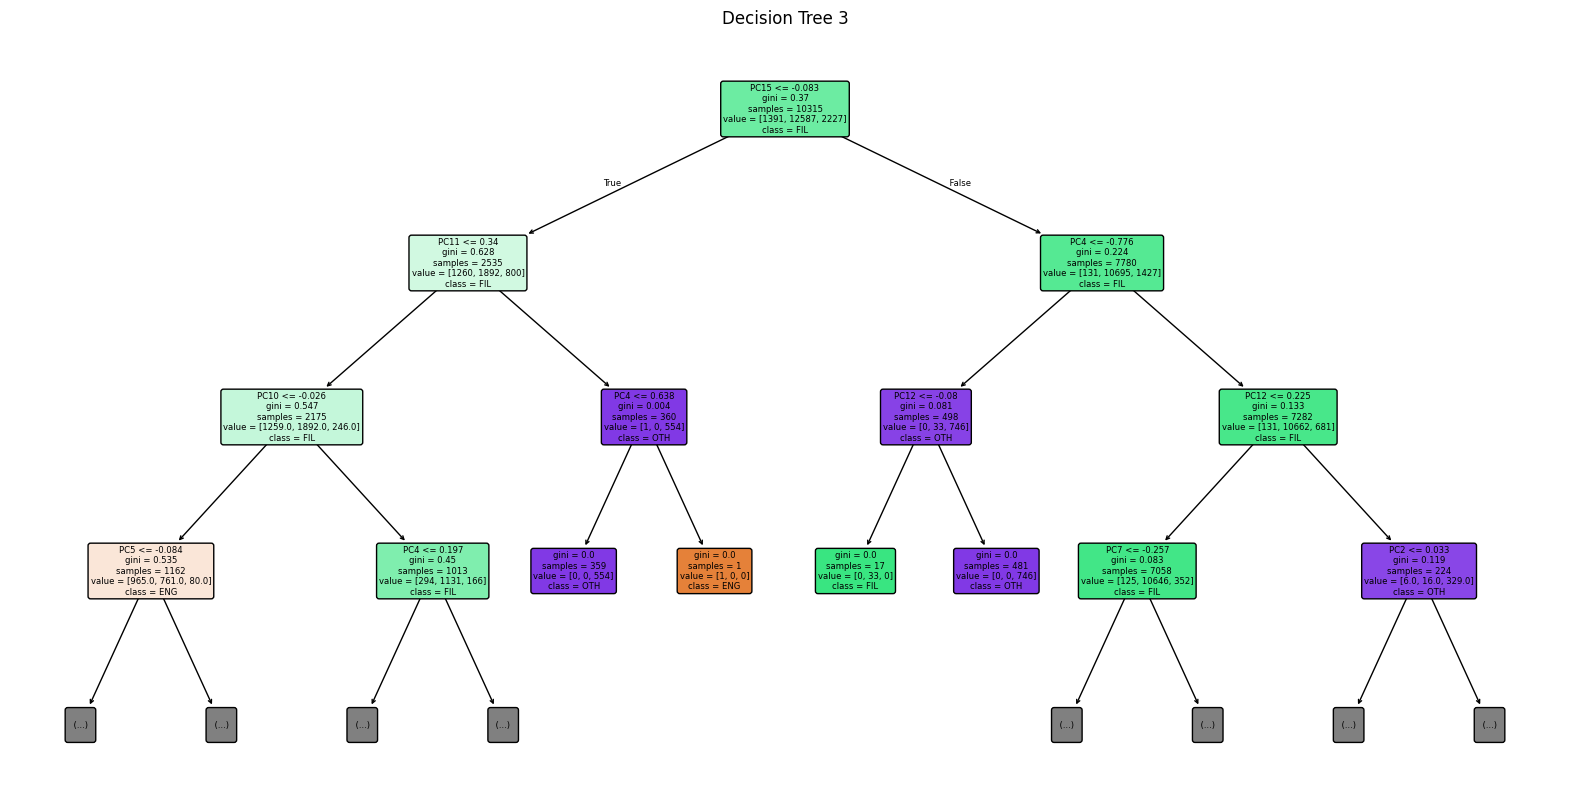

In [70]:
# Pick a few trees from your forest (since 300 is too many)
n_trees_to_plot = 3
for i in range(n_trees_to_plot):
    estimator = clf.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(
        estimator,
        filled=True,
        rounded=True,
        max_depth=3,  # limit depth for readability
        feature_names=[f"PC{i+1}" for i in range(X_train.shape[1])],
        class_names=[str(c) for c in clf.classes_],
    )
    plt.title(f"Decision Tree {i+1}")
    plt.show()

In [71]:
# Evaluate Model
print("Evaluating model...\n")
y_val_pred = clf.predict(X_val)
print("Validation Performance:")
print(classification_report(y_val, y_val_pred))

y_test_pred = clf.predict(X_test)
print("\nTest Performance:")
print(classification_report(y_test, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Evaluating model...

Validation Performance:
              precision    recall  f1-score   support

         ENG       0.93      0.91      0.92       288
         FIL       0.99      0.99      0.99      2692
         OTH       0.94      0.98      0.96       492

    accuracy                           0.98      3472
   macro avg       0.96      0.96      0.96      3472
weighted avg       0.98      0.98      0.98      3472


Test Performance:


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         ENG       0.94      0.89      0.91       288
         FIL       0.99      0.99      0.99      2693
         OTH       0.96      0.96      0.96       492

    accuracy                           0.98      3473
   macro avg       0.96      0.95      0.96      3473
weighted avg       0.98      0.98      0.98      3473

Test Accuracy: 0.9798


In [72]:
def tag_language(tokens: List[str]) -> List[str]:
    """
    Tags each token in the input list with its predicted language.

    Args:
        tokens: List of word tokens (strings).

    Returns:
        tags: List of predicted tags ("ENG", "FIL", or "OTH"), one per token.
    """
    # Generate Embeddings
    mpnet_model = SentenceTransformer('all-mpnet-base-v2')

    # Setup Named Entity Categories
    ne_categories = ["ABB", "ABB_EXPR", "ABB_NE", "EXPR", "NE", "NONE"]

    features = []

    for token in tokens:
        # Token embedding with Bert and MPNet
        mpnet_embedding = mpnet_model.encode([token], convert_to_tensor=False)[0]

        # Average the two embeddings
        token_embedding = (mpnet_embedding)

        # Classify if token is a Named Entity
        ne_token = classify_if_is_ne(token)

        # Create one-hot encoding for NE feature
        is_ne_onehot = np.zeros((1, len(ne_categories)))
        if ne_token in ne_categories:
            is_ne_onehot[0, ne_categories.index(ne_token)] = 1

        # Get Orthographic Features
        ortographic_features = np.array(get_ortographic_features(token))

        # Combine embeddings (same setup as main function)
        combined = np.hstack([token_embedding, ortographic_features, is_ne_onehot[0]])
        features.append(combined)

    # Stack all token feature vectors
    X = np.vstack(features)

    # Apply PCA
    X = pca.transform(X)

    # Predict tags
    predicted = clf.predict(X)

    return [str(tag) for tag in predicted]

In [73]:
from nltk import word_tokenize
nltk.download("punkt") 

sentences = pd.read_csv("../data/sentences.csv")

[nltk_data] Downloading package punkt to /home/mbchavez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# tokens = word_tokenize(sentences[sentences["sentence_id"] == 256]["sentence"].values[0])
tokens = word_tokenize("“Pag nagpe-pray kayo, wag nyong gayahin ang mga mapagkunwari! Mahilig silang mag-pray nang nakatayo sa mga synagogues at sa mga kanto para makita ng mga tao. Tandaan nyo, tinanggap na nila ang reward nila.”")

tags = tag_language(tokens)
print("\n-----\n")
print("Tokens:", tokens)
print("\n-----\n")
print("Tags:", tags)
print("\n-----\n")

/home/mbchavez/Coding/Learn/csintsy-projects/csintsy-mco2-pinoybot/venv/lib64/python3.13/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



-----

Tokens: ['Sheena', 'Halili', 'at', 'Baby', 'Martina', 'MARAMING', 'parents', 'ang', 'naka-relate', 'sa', 'pagiging', 'praning', 'na', 'mommy', 'ng', 'Kapuso', 'actress', 'na', 'si', 'Sheena', 'Halili', 'sa', 'gitna', 'pa', 'rin', 'ng', 'patuloy', 'na', 'banta', 'ng', 'pandemya', '.']

-----

Tags: ['OTH', 'OTH', 'FIL', 'FIL', 'FIL', 'FIL', 'ENG', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'ENG', 'FIL', 'FIL', 'ENG', 'FIL', 'FIL', 'OTH', 'OTH', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'OTH']

-----



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
